In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import wrds

from dotenv import dotenv_values
config = dotenv_values(".env")

from mylib.load_from_wrds import query_options_stock, query_zero_curve
from mylib.rates_tools import create_yield_curve, merge_interest
from mylib.construct_tracer import construct_tracer
from mylib.BS_formulas import bs_delta, bs_IV

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
secid = 113993
name = "Game Stop"
ticker = "GME"

startdate = '2019-01-01'
enddate = '2022-12-31'

ALLOWED_ADJ_FACTOR_CHANGE = [0.99, 1.01]    #to filter options where adjustment factor changes over lifetime

## AMC
# secid = 189943
# name = "AMC Theatres"
# ticker = "AMC"

## https://en.wikipedia.org/wiki/List_of_companies_affected_by_the_dot-com_bubble

# Download data from WRDS and do some preliminary cleaning

In [47]:
%%time

db = wrds.Connection(wrds_username=config['WRDS_USER'])

df_option = query_options_stock(db, secid, startdate=startdate, enddate=enddate)
zero_curve = query_zero_curve(db, startdate=startdate, enddate=enddate)

db.close()

Loading library list...
Done
CPU times: user 5.24 s, sys: 2.95 s, total: 8.2 s
Wall time: 56.3 s


In [48]:
print(df_option.shape)
df_option.head()

(1208674, 19)


,secid,optionid,date,exdate,cp_flag,IV0,delta,volume,open_interest,contract_size,tau_days,tau,K,V0,S0,adj_fac0,adj_fac_expiration,M0,open_total_interest
27,113993.0,126851960.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,0.005556,7.0,6.025,13.07,2.877128,2.877128,1.867143,92774.0
28,113993.0,126851961.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,0.005556,7.5,5.875,13.07,2.877128,2.877128,1.742667,92774.0
29,113993.0,126851962.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,0.005556,8.0,4.885,13.07,2.877128,2.877128,1.633750,92774.0
30,113993.0,126851963.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,0.005556,8.5,4.305,13.07,2.877128,2.877128,1.537647,92774.0
31,113993.0,126851964.0,2019-01-02,2019-01-04,C,NaN,NaN,0.0,0.0,100.0,2,0.005556,9.0,3.305,13.07,2.877128,2.877128,1.452222,92774.0


#### seperate notebook: write a function check the type of dividends and adjust the price to the level after the stock split:

!!!
option price

stock price

strike price

adjustment factor

In [49]:
def filter_adj_factor_change(df, ALLOWED_ADJ_FACTOR_CHANGE=[0.99, 1.01]):
    adj_change = df['adj_fac_expiration'] / df['adj_fac0']
    bl = (ALLOWED_ADJ_FACTOR_CHANGE[0] > adj_change) | (adj_change > ALLOWED_ADJ_FACTOR_CHANGE[1])    
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) options that are removed due to a large change in adjustment factor.')
    
    return df[~bl]

In [50]:
df_option = filter_adj_factor_change(df_option, ALLOWED_ADJ_FACTOR_CHANGE)

There are 128454 (10.63%) options that are removed due to a large change in adjustment factor.


Add interest rates and underlying info to options dataframe:

In [51]:
%%time

df_rate = create_yield_curve(zero_curve, max_days=1500) 
df = merge_interest(df_option, df_rate)

CPU times: user 1.84 s, sys: 1.33 s, total: 3.17 s
Wall time: 3.18 s


In [52]:
def add_next_observation(df):
    # adding future values to dataframe
    grouped = df.groupby('optionid')
    df['S1'] = grouped['S0'].shift(-1)
    df['r1'] = grouped['r'].shift(-1)
    df['IV1'] = grouped['IV0'].shift(-1)
    df['tau1'] = grouped['tau'].shift(-1)
    df['V1'] = grouped['V0'].shift(-1)
    return df

In [53]:
df = add_next_observation(df)

In [54]:
def filter_data_pre_tracer(df):
    orig_size = len(df)
    #-----------------------------------------
    # Filter by missing price data
    #-----------------------------------------
    bl = df['S0'].isnull() | df['V0'].isnull() | df['S1'].isnull() | df['V1'].isnull()
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due missing price data.')   
    #these are options with zero days to maturity or at the enddate
    df = df.loc[~bl]

    #-----------------------------------------
    # Filter by open_interest
    #-----------------------------------------
    bl = df['open_interest'].eq(0)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed because of zero interest.')   
    #these are options with zero days to maturity or at the enddate
    df = df.loc[~bl]

    #----------------------
    #  filter by volume and open interest
    #----------------------    
    CUTOFF_DAILY_INTEREST = 0.01
    bl = df['volume'].eq(0) & df['open_interest'].div(df['open_total_interest']).lt(CUTOFF_DAILY_INTEREST)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due no volume and small open interest.')
    df = df[~bl]

    n_removed = orig_size - len(df)
    print(f'Removed in total: {n_removed} ({n_removed/orig_size*100:.2f}%) of all options. New data size: {len(df)}.') 
    return df

In [55]:
df = filter_data_pre_tracer(df)

There are 29308 (2.71%) option days that are removed due missing price data.
There are 226941 (21.59%) option days that are removed because of zero interest.
There are 336682 (40.86%) option days that are removed due no volume and small open interest.
Removed in total: 592931 (54.89%) of all options. New data size: 487289.


# Construct tracer options and calculate implied dividends

In [ ]:
%%time

df_tracer = pd.DataFrame()
for target_tau_days in [10, 20, 30, 45, 60, 75, 90, 120, 150, 180, 210]:
    for cp_flag in ['C', 'P']:
        df_tmp = construct_tracer(df, df_rate, cp_flag, target_tau_days, ALLOWED_ADJ_FACTOR_CHANGE)
        df_tracer = pd.concat([df_tracer, df_tmp])

In [ ]:
def calc_implied_div(df_tracer):
    df_c = df_tracer[(df_tracer['cp_flag'] == 'C')]
    df_p = df_tracer[(df_tracer['cp_flag'] == 'P')]
    df = df_c.merge(df_p, on=['date', 'K', 'tau_days'], suffixes=[None, '_P'])
    df['impl_div'] = np.maximum(-1/df['tau'] * np.log((df['V0'] - df['V0_P'])/df['K'] + np.exp(-df['r'] * df['tau'])), 0)    
    return df[['date', 'tau_days', 'impl_div']]

In [ ]:
## calculate implied dividend
df_impl_div = calc_implied_div(df_tracer)
df_impl_div.tail()

In [ ]:
df_impl_div.pivot(index='date', columns='tau_days')['impl_div'][[30, 60]].plot();

In [ ]:
df[['date', 'S0']].drop_duplicates().merge(df_impl_div[df_impl_div['tau_days']==30][['date', 'impl_div']], 
                                           on='date').set_index('date', drop=True).plot(subplots=True);

#!!! check again plot after price adjustment is implemented

In [ ]:
df_tracer = pd.merge(df_tracer, df_impl_div, how='left', on=['date', 'tau_days'])
df_tracer['adjDelta'] = bs_delta(
    df_tracer['IV0'], df_tracer['K'], df_tracer['K'], df_tracer['tau'], df_tracer['r'], df_tracer['impl_div'], df_tracer['cp_flag'])

# Filter data

In [18]:
def filter_data_post_tracer(df):
    orig_size = len(df)

    #---------------------------------
    # Keep out-the-money options only
    #---------------------------------
    bl = ((df['cp_flag'] == 'C') & (df['M0'] > 1.001)) | ((df['cp_flag'] == 'P') & (df['M0'] < 0.999))
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due being in-the-money.')
    df = df.loc[~bl]


    #---------------------------------
    # Keep out-the-money options only
    #---------------------------------
    bl = ((df['cp_flag'] == 'C') & (df['M0'] < 0.8)) | ((df['cp_flag'] == 'P') & (df['M0'] > 1.25))
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed because they are too far out of-the-money.')
    df = df.loc[~bl]
    

    #--------------------
    # Filter by Maturity, part I
    #--------------------
    bl = df['tau_days'].le(5)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due being too close to expiry.')
    df = df[~bl]


    #--------------------
    # Filter by Maturity, part II
    #--------------------
    bl = df['tau'].gt(1)
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due to time to expiry larger than 1 year.')
    df = df[~bl]
    
    
    #----------------------------------------------------
    #  filter all the option with negative time value
    #----------------------------------------------------
    bl_c = (df['cp_flag'] == 'C') & (df['S0'] - np.exp(-df['r'] * df['tau']) * df['K'] >= df['V0'])
    bl_p = (df['cp_flag'] == 'P') & (np.exp(-df['r'] * df['tau']) * df['K'] - df['S0'] >= df['V0'])
    bl = bl_c | bl_p
    print(f'There are {bl.sum()} ({bl.sum()/len(bl)*100:.2f}%) option days that are removed due negative time value.')   
    df = df.loc[~bl]

    
    n_removed = orig_size - len(df)
    print(f'Removed in total: {n_removed} ({n_removed/orig_size*100:.2f}%) of all options. New data size: {len(df)}.') 
    return df

In [19]:
df = filter_data_post_tracer(df)

There are 147145 (30.20%) options that are removed due being in-the-money.
There are 242794 (71.38%) options that are removed because they are too far out of-the-money.
There are 14493 (14.89%) options that are removed due being too close to expiry.
There are 2675 (3.23%) options that are removed due to time to expiry larger than 1 year.
There are 0 (0.00%) options that are removed due negative time value.
Removed in total: 407107 (83.55%) of all options. New data size: 80182.


# Fill in implied vols and compute deltas

In [20]:
%%time
## fill in implied vols
df['IV0_is_inputed'] = df['IV0'].isna()
df.loc[df['IV0'].isna(), 'IV0'] = df.loc[df['IV0'].isna(), :].apply(lambda x:bs_IV(**x), axis=1)

CPU times: user 4.74 s, sys: 41.1 ms, total: 4.78 s
Wall time: 4.78 s


In [21]:
## merge implied dividends with options df
df_impl_div_wide = df_impl_div.pivot(index='date', columns='tau_days')['impl_div'].ffill(axis=1).bfill(axis=1)
df_impl_div_wide[1] = df_impl_div_wide[min(df_impl_div_wide.columns)]
max_tau_days = df['tau_days'].max()
df_impl_div_wide[max_tau_days] = df_impl_div_wide[max(df_impl_div_wide.columns)]
tmp_df = pd.DataFrame(
    np.nan, columns=list(set(np.arange(2, max_tau_days)).difference(df_impl_div_wide.columns)), index=df_impl_div_wide.index)
df_impl_div_wide = pd.concat([df_impl_div_wide, tmp_df], axis=1)
df_impl_div_wide = df_impl_div_wide.reindex(sorted(df_impl_div_wide.columns), axis=1)
df_impl_div_wide = df_impl_div_wide.interpolate(axis=1).reset_index()
df_impl_div_narrow = pd.melt(df_impl_div_wide, id_vars='date', var_name='tau_days', value_name='impl_div')
df = pd.merge(df, df_impl_div_narrow, on=['date', 'tau_days'], how='left')

In [22]:
max_tau_days

252

In [23]:
df['normDelta'] = bs_delta(df['IV0'], df['S0'], df['K'], df['tau'], df['r'], 0, df['cp_flag'])
df['delta_is_inputed'] = df['delta'].isna()
df.loc[df['delta'].isna(), 'delta'] = df.loc[df['delta'].isna(), 'normDelta'] 
df['adjDelta'] = bs_delta(df['IV0'], df['S0'], df['K'], df['tau'], df['r'], df['impl_div'], df['cp_flag'])

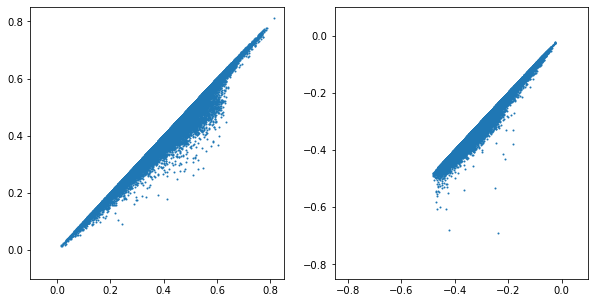

In [24]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))         
axs[0].scatter(df.loc[df['cp_flag'] == 'C', 'normDelta'], df.loc[df['cp_flag'] == 'C', 'adjDelta'], s=1)
axs[0].set_ylim([-0.1, 0.85])
axs[0].set_xlim([-0.1, 0.85])
axs[1].scatter(df.loc[df['cp_flag'] == 'P', 'normDelta'], df.loc[df['cp_flag'] == 'P', 'adjDelta'], s=1)
axs[1].set_ylim([- 0.85, 0.1])
axs[1].set_xlim([- 0.85, 0.1]);

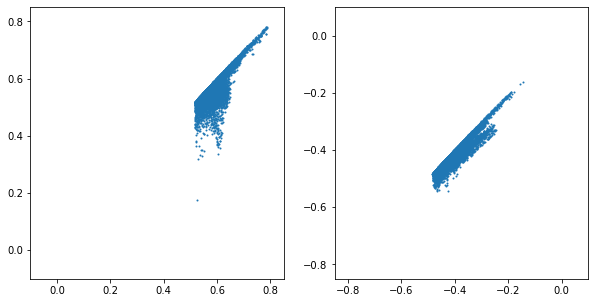

In [25]:
_, axs = plt.subplots(1, 2, figsize=(10, 5))         
axs[0].scatter(df_tracer.loc[df_tracer['cp_flag'] == 'C', 'normDelta'], df_tracer.loc[df_tracer['cp_flag'] == 'C', 'adjDelta'], s=1)
axs[0].set_ylim([-0.1, 0.85])
axs[0].set_xlim([-0.1, 0.85])
axs[1].scatter(df_tracer.loc[df_tracer['cp_flag'] == 'P', 'normDelta'], df_tracer.loc[df_tracer['cp_flag'] == 'P', 'adjDelta'], s=1)
axs[1].set_ylim([- 0.85, 0.1])
axs[1].set_xlim([- 0.85, 0.1]);



4) do some scatter plots for the various deltas (on the origianl dataset, and maybe also on the tracer dataset)


In [26]:
df_syn = df_tracer.copy()
# missing values: should be revised later
# drop missing values:
df_syn = df_syn.loc[~np.isnan(df_syn['IV0']), :]
df_syn = df_syn.loc[~np.isnan(df_syn['S1']), :]
df_syn = df_syn.loc[~np.isnan(df_syn['V1']), :]
df_syn = df_syn.loc[~np.isnan(df_syn['adjDelta']), :]

df_syn.head(2)

,date,S0,S1,IV0,K,cp_flag,tau_days,tau,short_rate,r,V0,V1,normDelta,impl_div,adjDelta
0,2019-01-02,13.07,12.97,0.651347,13.07,C,10,0.027778,0.024478,0.024592,0.570042,0.483918,0.524150,0.000000,0.524150
3,2019-01-07,15.48,15.81,0.605518,15.48,C,10,0.027778,0.024378,0.024549,0.628056,0.820039,0.522814,0.331321,0.486447


# Regression

In [38]:
def func_reg(train, test, weight, cp_flag, delta_var = 'adjDelta'): 
    
    df_train = train.query("cp_flag==@cp_flag").copy()
    df_test = test.query("cp_flag==@cp_flag").copy()

    delta_hat = pd.Series(index=df_test.index, dtype = 'float64')
    dict_output = {}
    dict_plot = {}
    dict_coef = {}        

    ## add weights
    group = pd.merge(df_train, weight, how = 'left', on = 'date')

    ## y_train is the change of option price in the training set
    y_train = group['V1'] - group['V0'] * group['gross_rate']
    ## x_train is Delta times the change of stock price in the training set
    w_train = group.loc[:, 'weight'].copy()
    x_train = group.loc[:, delta_var].copy()
    x_train = x_train.multiply(group['S1'] - group['S0'] * group['gross_rate'], axis=0).values.reshape(-1,1)
    lin = LinearRegression(fit_intercept=False).fit(x_train, y_train, sample_weight = group['weight'])
    coef = lin.coef_
    
    dict_plot[cp_flag + '_x_train'] = x_train
    dict_plot[cp_flag + '_y_train'] = y_train
    dict_plot[cp_flag + '_w_train'] = w_train
    dict_plot[cp_flag + '_coef'] = coef

    ## y_hat_test is predicted delta in the test set 
    if len(df_test[(df_test['cp_flag'] == cp_flag)]) < 1:
        print('test set of ' + cp_flag + ' has insufficient observations')
        pass
    else:
        delta_hat = lin.predict(df_test[delta_var].values.reshape(-1,1))

        y_test = df_test['V1'] - df_test['V0'] * df_test['gross_rate']
        x_test = df_test[delta_var].copy()
        x_test = x_test.multiply(df_test['S1'] - df_test['S0'] * df_test['gross_rate'], axis=0).values.reshape(-1,1)  

        dict_plot[cp_flag + '_x_test'] = x_test
        dict_plot[cp_flag + '_y_test'] = y_test
        dict_plot[cp_flag + '_predict'] = lin.predict(x_test)   

    dict_coef['coef'] = coef
    dict_coef['N_train'] = len(group)
    dict_coef['days_train'] = len(np.unique(group.date))
    dict_coef['N_test'] = len(df_test)
    dict_coef['days_test'] = len(np.unique(df_test.date))
    dict_output[cp_flag] = dict_coef
    
    return dict_output, dict_plot

In [51]:
%%time
from sklearn.linear_model import LinearRegression

flag = "raw" 
if flag == "tracer":
    temp = df_syn.copy()
    delta_type = "normDelta"
else:
    temp = df.copy()
    delta_type = "normDelta"
    
temp = temp.loc[temp['IV0'].notna(), :]
temp = temp.loc[temp[delta_type].notna(), :]
temp['gross_rate'] = np.exp(temp['short_rate']/252)

############# Calculating result using pre-bubble data ####################
df_MSHE = pd.DataFrame()
df_PNL = pd.DataFrame()
dict_output = {}
dict_plot = {}

train_length = 240
wt_exp = [0.99**i for i in range(train_length-1, -1, -1)]

all_date = np.unique(temp.loc[:, 'date'])
train_date = all_date[0:train_length]
test_date = all_date[train_length:]

for _ in range(len(test_date)):
        
    df_train_rolling = temp[temp['date'].isin(train_date)]
    df_test_rolling = temp[temp['date'].isin([test_date[0]])]
    df_weight_rolling = pd.DataFrame({'date':train_date, 'weight':wt_exp})
    
    dict_output_one_C, dict_plot_one_C = func_reg(df_train_rolling, df_test_rolling, df_weight_rolling, 'C', delta_type)
    dict_output_one_P, dict_plot_one_P = func_reg(df_train_rolling, df_test_rolling, df_weight_rolling, 'P', delta_type)

    first_test_date = str(test_date[0])[:10]
    dict_output_one = {**dict_output_one_C, **dict_output_one_P}
    dict_plot_one = {**dict_plot_one_C, **dict_plot_one_P}
    dict_output[first_test_date] = dict_output_one
    dict_plot[first_test_date] = dict_plot_one
    
    train_date = np.concatenate([train_date[1:], [test_date[0]]])
    test_date = test_date[1:]
    
df_coef_ts = pd.DataFrame()
for key in dict_output:
    df_coef_ts.loc[key, 'date'] = pd.to_datetime(key)
    df_coef_ts.loc[key, 'coef_C'] = dict_output[key]['C']['coef']
    df_coef_ts.loc[key, 'N_train_C'] = dict_output[key]['C']['N_train']
    df_coef_ts.loc[key, 'days_train_C'] = dict_output[key]['C']['days_train']
    df_coef_ts.loc[key, 'N_test_C'] = dict_output[key]['C']['N_test']

    df_coef_ts.loc[key, 'coef_P'] = dict_output[key]['P']['coef']
    df_coef_ts.loc[key, 'N_train_P'] = -dict_output[key]['P']['N_train']
    df_coef_ts.loc[key, 'days_train_P'] = dict_output[key]['P']['days_train']
    df_coef_ts.loc[key, 'N_test_P'] = dict_output[key]['P']['N_test']   
    

test set of C has insufficient observations
test set of C has insufficient observations
CPU times: user 10.8 s, sys: 1.19 s, total: 11.9 s
Wall time: 12.1 s


# plot scatter:

In [52]:
def plot_scatter(dict_plot_input, secid, date_in):
    
    dict_plot_one = dict_plot_input[date_in]
    plt.rc('font', size=25)          # controls default text sizes

    fig, axs = plt.subplots(1, 2, figsize=(18,9), sharex=True, sharey=True)
    # fig.suptitle(ticker + ' ' + str(i) + ' ' + ids[i].strip() + ' ' + date_in)
    plt.setp(axs[:], xlabel= "Adjusted delta X Change of stock price")
    plt.setp(axs[0], ylabel="Change of option price")
    
    w_C = dict_plot_one['C_w_train'] * 30
    axs[0].scatter(dict_plot_one['C_x_train'], dict_plot_one['C_y_train'], s = w_C)
    axs[0].plot(dict_plot_one['C_x_train'], dict_plot_one['C_coef'] * dict_plot_one['C_x_train'], color='tab:orange')
    axs[0].scatter(dict_plot_one['C_x_test'], dict_plot_one['C_y_test'], color='tab:red')
    axs[0].annotate('Call Coefficient: ' + str(round(dict_plot_one['C_coef'][0], 4)), 
                    xy=(0, 1), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points')
    axs[0].set_title("Call")
    
    w_P = dict_plot_one['P_w_train'] * 30
    axs[1].scatter(dict_plot_one['P_x_train'], dict_plot_one['P_y_train'], s = w_P)
    axs[1].plot(dict_plot_one['P_x_train'], dict_plot_one['P_coef'] * dict_plot_one['P_x_train'], color='tab:orange')
    axs[1].scatter(dict_plot_one['P_x_test'], dict_plot_one['P_y_test'], color='tab:red')
    axs[1].annotate('Put Coefficient: ' + str(round(dict_plot_one['P_coef'][0], 4)), 
                    xy=(0, 1), xytext=(12, -12), va='top', xycoords='axes fraction', textcoords='offset points')
    axs[1].set_title("Put")   
    fig.tight_layout()   
    plt.close()
    return fig

    # scatter_output_path = output_path + 'scatter/' + str(secid) + '/'
    # if not os.path.exists(scatter_output_path):
    #     os.makedirs(scatter_output_path)
    # plt.savefig(scatter_output_path + str(secid) + '_' + ticker + '_' + date_in + '.jpg')  
    # plt.close()

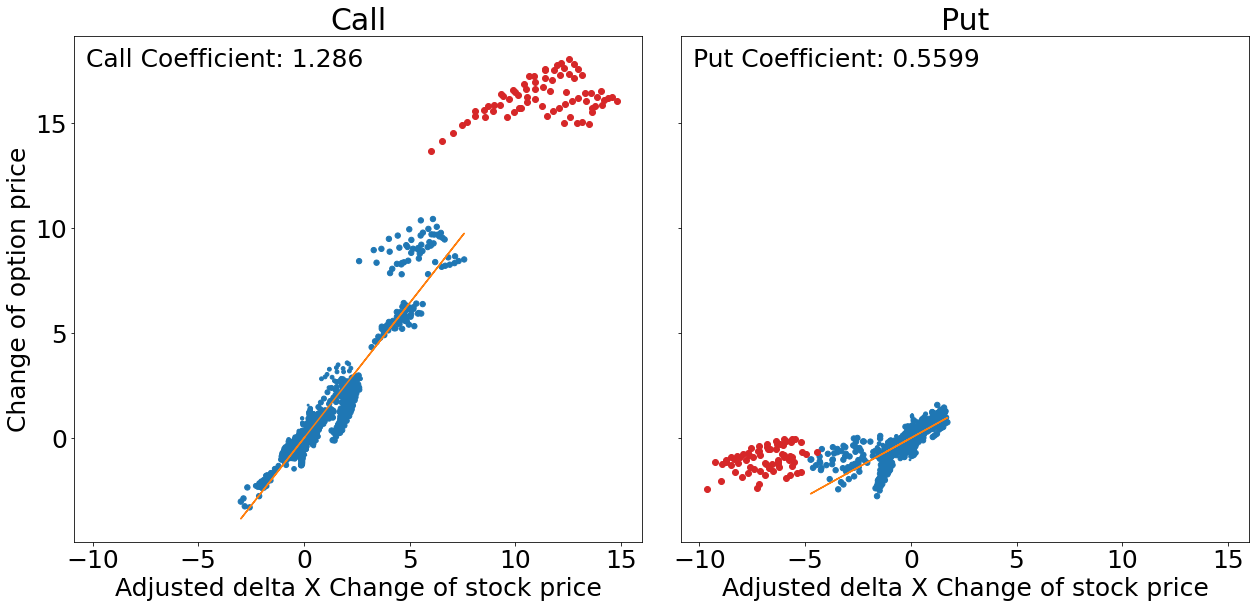

In [53]:
import matplotlib.pyplot as plt
plot_scatter(dict_plot, secid, '2021-01-21')

# plot coefficient:

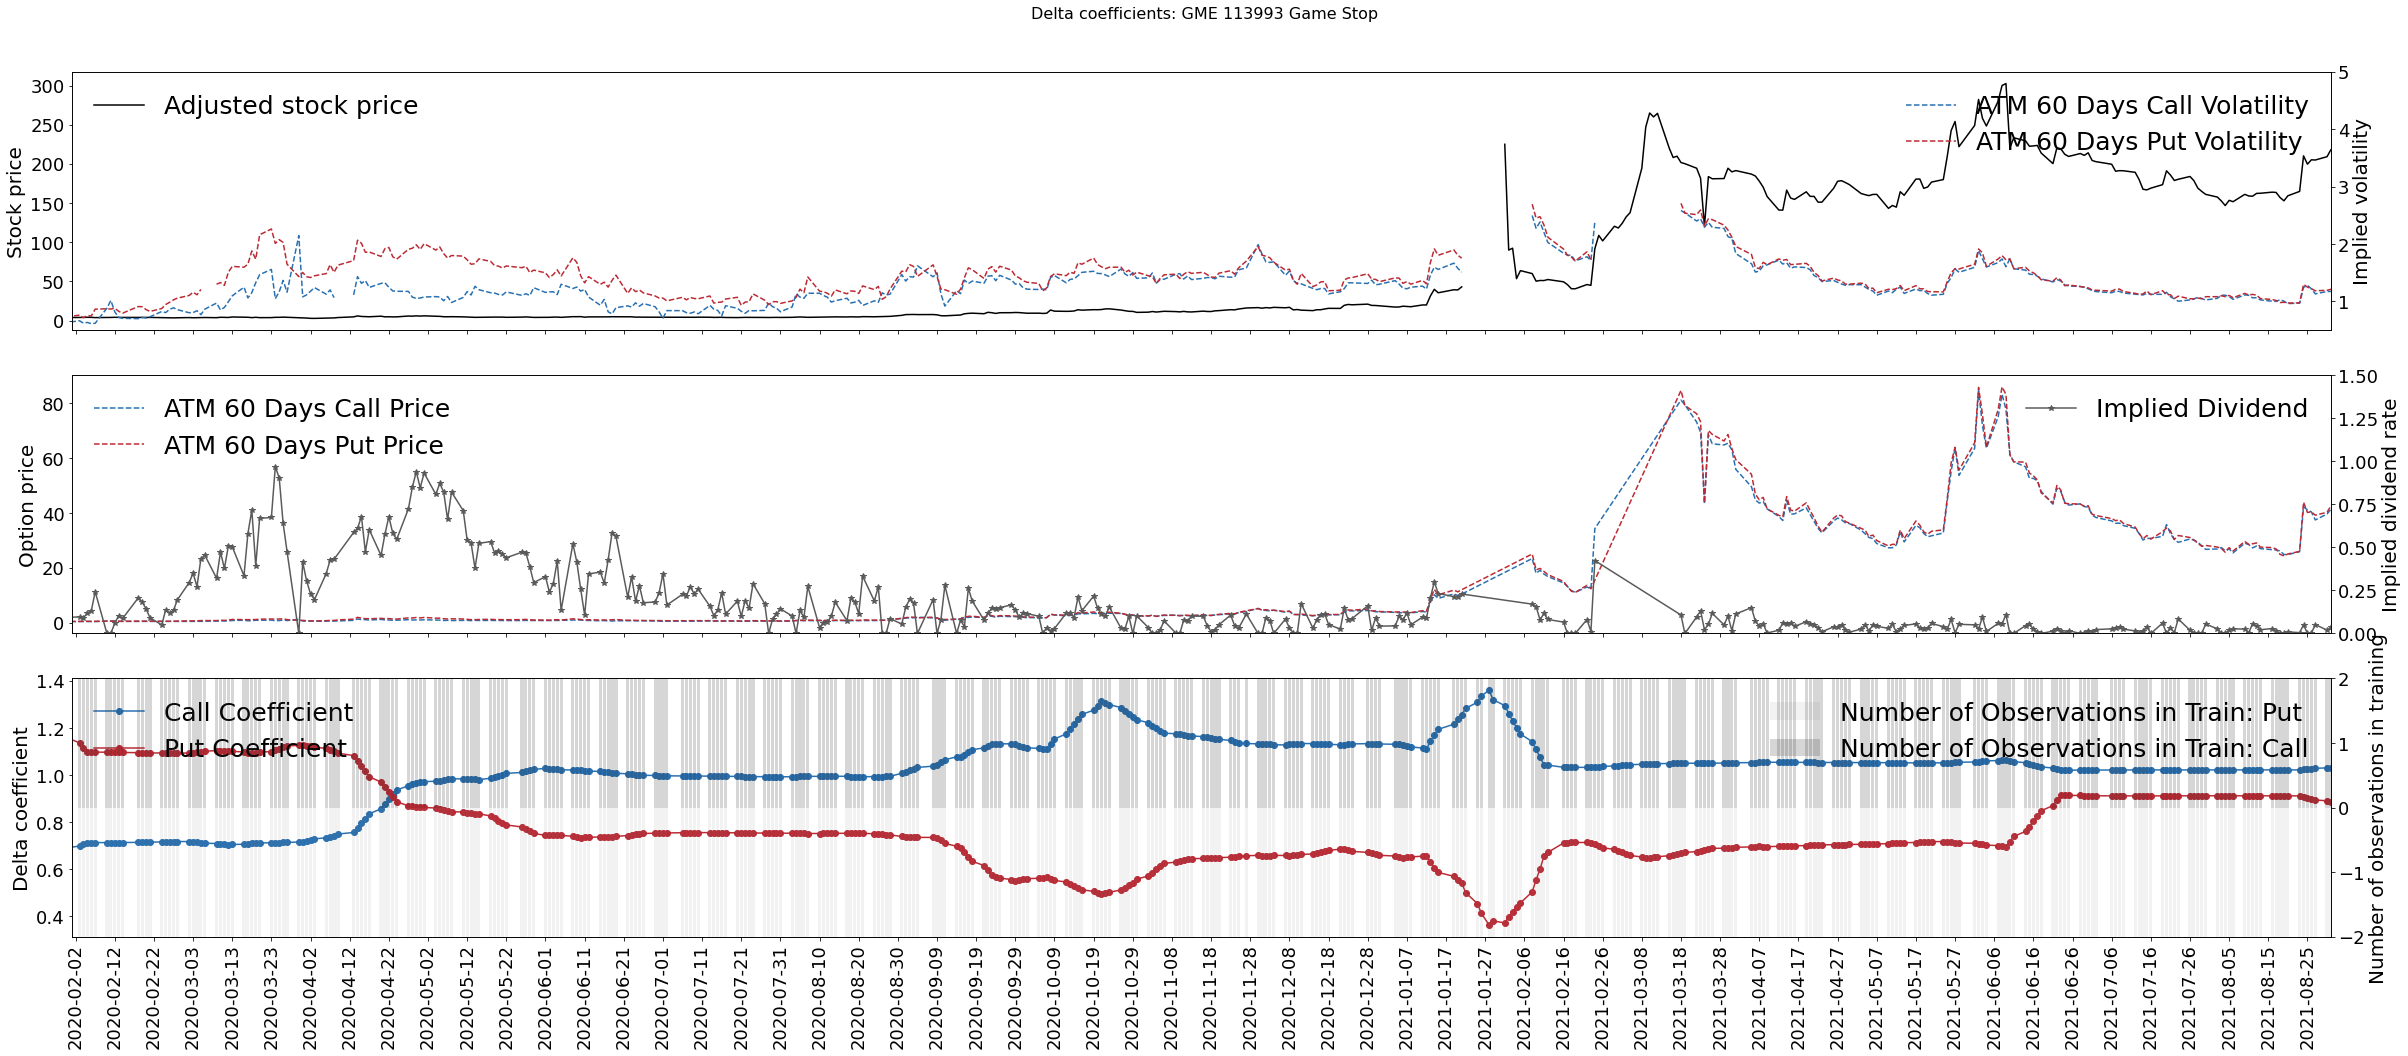

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

df_syn_impl_div_C60 = df_syn.loc[(df_syn['tau_days'] == 60) & (df_syn['cp_flag'] == 'C'),['date', 'V0', 'impl_div']]   
df_syn_impl_div_P60 = df_syn.loc[(df_syn['tau_days'] == 60) & (df_syn['cp_flag'] == 'P'),['date', 'V0', 'impl_div']]   

df_coef_ts['dif'] = df_coef_ts['coef_C'] - df_coef_ts['coef_P']
df_coef_ts = df_coef_ts.sort_values(['date'])
df_coef_ts['coef_C_SMA10'] = df_coef_ts['coef_C'].rolling(10).mean()
df_coef_ts['coef_P_SMA10'] = df_coef_ts['coef_P'].rolling(10).mean()
df_coef_ts['EWMA10'] = df_coef_ts['dif'].ewm(span=10).mean()
df_coef_ts['SMA10'] = df_coef_ts['dif'].rolling(10).mean()

df_coef_ts_plot = df_coef_ts.merge(df_syn[['date', 'S0']].drop_duplicates(), how = 'left', on = 'date')
df_coef_ts_plot = df_coef_ts_plot.merge(df_syn.loc[(df_syn['tau_days'] == 60) & (df_syn['cp_flag'] == 'C') , ['date', 'IV0']].drop_duplicates(), how = 'left', on = 'date')
df_coef_ts_plot.rename(columns={'IV0': 'IV_C60'}, inplace = True)
df_coef_ts_plot = df_coef_ts_plot.merge(df_syn.loc[(df_syn['tau_days'] == 60) & (df_syn['cp_flag'] == 'P') , ['date', 'IV0']].drop_duplicates(), how = 'left', on = 'date')
df_coef_ts_plot.rename(columns={'IV0': 'IV_P60'}, inplace = True)


fig, axs = plt.subplots(3, 1, figsize=(34,15), sharex=True, sharey=False)                
axs[0].plot(df_coef_ts_plot.date, df_coef_ts_plot.S0, 'k', label='Adjusted stock price')
axs[0].set_ylabel("Stock price", fontsize=20)
axs[0].tick_params(axis='y', labelsize=18)    
axs[0].legend(loc=2, frameon=False)
ax0 = axs[0].twinx()
ax0.plot(df_coef_ts_plot.date, df_coef_ts_plot.IV_C60, color = sns.color_palette("RdBu", n_colors=7)[6], linestyle='dashed', label='ATM 60 Days Call Volatility')
ax0.plot(df_coef_ts_plot.date, df_coef_ts_plot.IV_P60, color = sns.color_palette("RdBu", n_colors=7)[0], linestyle='dashed', label='ATM 60 Days Put Volatility')
ax0.set_ylabel("Implied volatility", fontsize=20) 
ax0.tick_params(axis='y', labelsize=18)    
ax0.set_ylim([0.5, 5]) 
ax0.legend(loc=1, frameon=False)  

axs[1].plot(df_syn_impl_div_C60.date, df_syn_impl_div_C60.V0, color = sns.color_palette("RdBu", n_colors=7)[6], linestyle='dashed', label='ATM 60 Days Call Price')
axs[1].plot(df_syn_impl_div_P60.date, df_syn_impl_div_P60.V0, color = sns.color_palette("RdBu", n_colors=7)[0], linestyle='dashed', label='ATM 60 Days Put Price')
axs[1].set_ylabel("Option price", fontsize=20)
axs[1].tick_params(axis='y', labelsize=18)
axs[1].legend(loc=2, frameon=False)
ax1 = axs[1].twinx()
ax1.plot(df_syn_impl_div_C60.date, df_syn_impl_div_C60.impl_div, color = sns.color_palette("RdGy", n_colors=7)[6], marker = '*', label='Implied Dividend')
ax1.set_ylabel("Implied dividend rate", fontsize=20)
ax1.tick_params(axis='y', labelsize=18)
ax1.set_ylim([0, 1.5]) 
ax1.legend(loc=1, frameon=False)  

#     axs[2].plot(df_coef_ts.date, df_coef_ts.EWMA10, 'bo', label='EWMA 10')
#     axs[2].plot(df_coef_ts.date, df_coef_ts.SMA10, 'ro', label='SMA 10') 
axs[2].plot(df_coef_ts_plot.date, df_coef_ts_plot.coef_C_SMA10, color = sns.color_palette("RdBu", n_colors=7)[6], marker = 'o', label='Call Coefficient')
axs[2].plot(df_coef_ts_plot.date, df_coef_ts_plot.coef_P_SMA10, color = sns.color_palette("RdBu", n_colors=7)[0], marker = 'o', label='Put Coefficient') 
axs[2].set_ylabel("Delta coefficient", fontsize=20)
axs[2].tick_params(axis='y', labelsize=18)    
# axs[2].set_ylim([0, 2])            
axs[2].legend(loc=2, frameon=False)
ax2 = axs[2].twinx()
ax2.bar(df_coef_ts_plot.date, df_coef_ts_plot.N_train_P, color=(0.5, 0.5, 0.5, 0.1), label = "Number of Observations in Train: Put")
ax2.bar(df_coef_ts_plot.date, df_coef_ts_plot.N_train_C, color=(0.2, 0.2, 0.2, 0.2), label = "Number of Observations in Train: Call")
ax2.set_ylabel("Number of observations in training", fontsize=20)  
ax2.tick_params(axis='y', labelsize=18)
maxlevel = round(max([max(abs(df_coef_ts_plot.N_train_C)), max(abs(df_coef_ts_plot.N_train_P))])/1000)*1000 + 1000
ax2.set_ylim([-2, 2]) 
ax2.legend(loc=1, frameon=False) 
axs[2].xaxis.set_major_locator(mdates.DayLocator(interval=10))
axs[2].set_xlim([pd.to_datetime('2020-02-01'), pd.to_datetime('2021-08-31')])
plt.setp(axs[2].get_xticklabels(), rotation=90, fontsize=18)

fig.suptitle('Delta coefficients: ' + ticker + ' ' + str(secid) + ' ' + name.strip(), fontsize=16, x = 0.5, y = 0.99)
fig.tight_layout()
# plt.savefig(output_path + 'coefplot/' + str(secid) + '_' + ticker + '.jpg')
# plt.close(fig)